# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using the following Baseline Method:
## Confidence from Invariance to Image Transformations
https://arxiv.org/pdf/1804.00657.pdf

## 1. Import Libraries

In [1]:
%matplotlib inline
# python libraries
from matplotlib.patches import Rectangle
import natsort as ns
from multiprocessing import cpu_count
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider
from sklearn.manifold import TSNE
import sys

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from sklearn import decomposition
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras.models import Sequential
from keras.optimizers import Adam

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11274641904313718126
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3804889088
locality {
  bus_id: 1
}
incarnation: 12142368112609533199
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [2]:
# Meta-Parameters
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
#base_dir = '/home/cyrilwendl'  # for GCE
base_dir = '/raid/home/cwendl'  # for guanabana

class_to_remove = 1

In [3]:
# custom libraries
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package
from density_tree.density_forest import *
from density_tree.helpers import print_density_tree_latex
from helpers.helpers import imgs_stretch_eq

## 2. Load Images

In [4]:
path = os.getcwd()

im_dir = r'' + path + '/Zurich_dataset/images_tif/'
gt_dir = r'' + path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

imgs = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])

# histogram stretching
imgs_eq = imgs_stretch_eq(imgs)
imgs = imgs_eq  # continue using stretched image

images: 20 
ground truth images: 20 


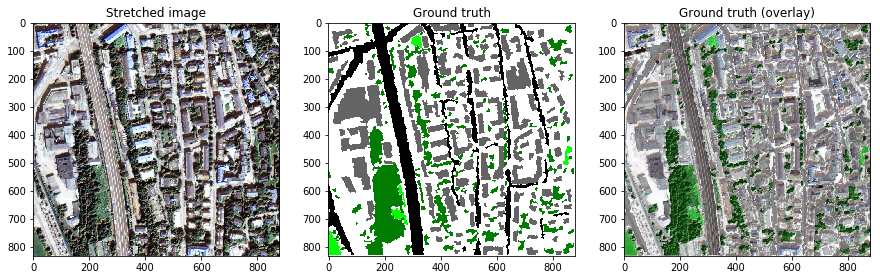

In [5]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 1
alpha=.6
overlay = imgs_eq[i][:, :, :3] * alpha + gt[i] / 255 * (1-alpha)

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs[i][..., :3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

### 2.1. GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [6]:
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

gt_maj_label = gt_color_to_label(gt, colors)

100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


In [7]:
# Load Images
def flatten(l):
    return [item for sublist in l for item in sublist]


flat_labels = flatten(flatten(gt_maj_label))
print("Unique Labels in GT: ", np.unique(flat_labels))
print(np.shape(gt_maj_label))
gt = gt_maj_label

Unique Labels in GT:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
(20,)


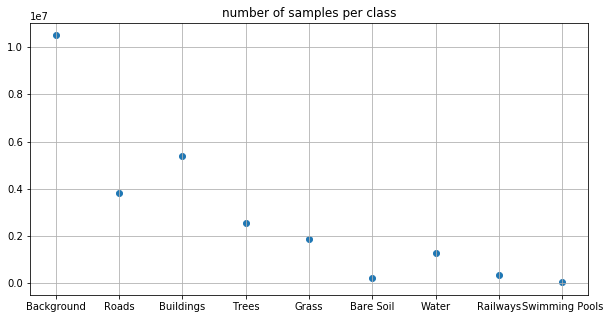

In [8]:
# print some statistics for the class distribution
unique, counts = np.unique(flat_labels, return_counts=True)
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(unique, counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

### 2.2. Get patches

In [9]:
# Get patches
patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)
print(y_test_nostride.shape)

100%|██████████| 4/4 [00:00<00:00, 85.80it/s]

(3902, 64, 64, 4)
(964, 64, 64, 4)
(964, 64, 64)


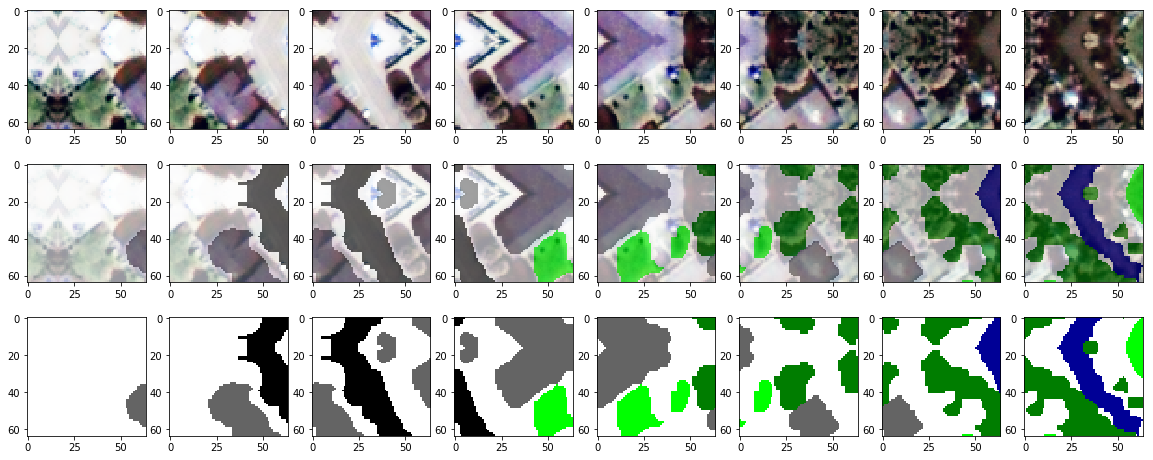

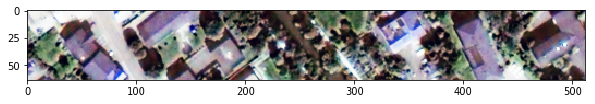

In [10]:
# visualize some patches 
imgs_row = 8
fig, axes = plt.subplots(3, imgs_row)
fig.set_size_inches(20, 8)
offset = 0
alpha = .6
for i in range(offset, offset + imgs_row):
    axes[0][i - offset].imshow(x_test[i][..., :3])  # images
    axes[1][i - offset].imshow(
        gt_label_to_color(y_test[i], colors) * alpha + x_test[i][..., :3] * (1 - alpha))  # ground truth (overlay)
    axes[2][i - offset].imshow(gt_label_to_color(y_test[i], colors))  # ground truth

# corresponding part of image
plt.figure(figsize=(10, 5))
plt.imshow(imgs[16][:64, :64 * 8, :3])

## 3. Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [11]:
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [12]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [13]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

classes to keep: ['Buildings', 'Trees', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


### 3.1. Train CNN

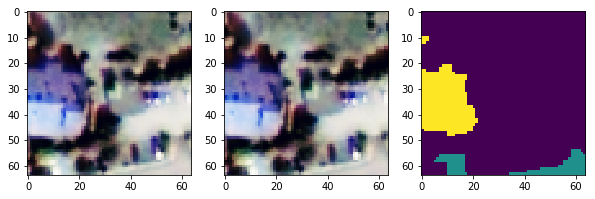

In [14]:
# data augmentation
img_idx = 14
im_vis, gt_vis = augment_images_and_gt(x_train[img_idx], y_train_label[img_idx], rf_h=True,
                                                   rf_v=True, rot=True, contrast=True, force=True)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches((10, 5))
axes[0].imshow(x_train[img_idx][..., :3])
axes[1].imshow(im_vis[..., :3])
axes[2].imshow(gt_vis)
plt.show()

In [15]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

<Figure size 432x288 with 0 Axes>

In [16]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)
#model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [17]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### 3.2. Prediction on Test Set

In [18]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)

# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# get label
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# Get accuracy as margin between highest and second highest class
y_pred_acc = get_accuracy_probas(y_pred)

3902/3902 [==============================] - 4s 1ms/step


100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


In [19]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[...,np.newaxis],
                                       img_idx=idx_im, img_start=ids_test[0], patch_size=64,
                                       stride=64) for idx_im in ids_test]

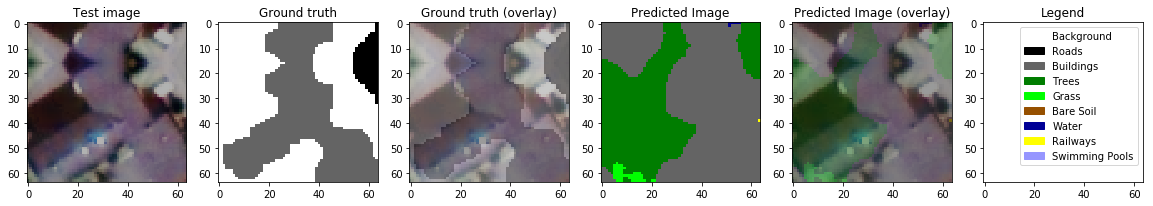

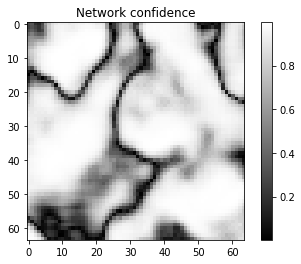

In [20]:
# plot prediction results
im_idx = 15
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_test[im_idx][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_test_label[im_idx], colors)
fig_pred = gt_label_to_color(y_pred_label[im_idx], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = np.asarray([n for n, c in legend_data])
axes[5].legend(handles, labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.title("Network confidence")
plt.colorbar()

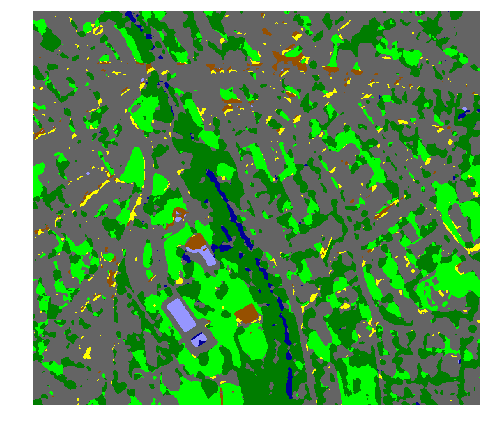

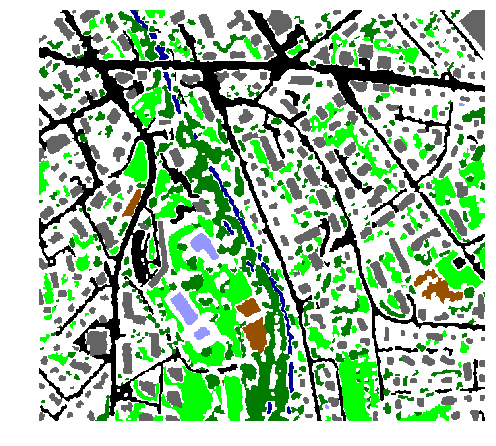

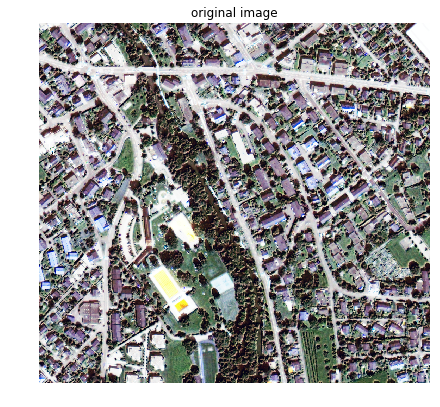

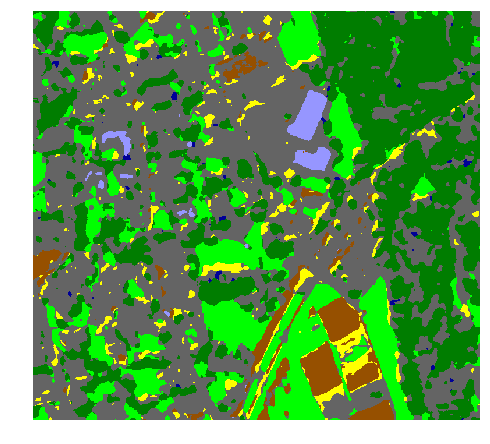

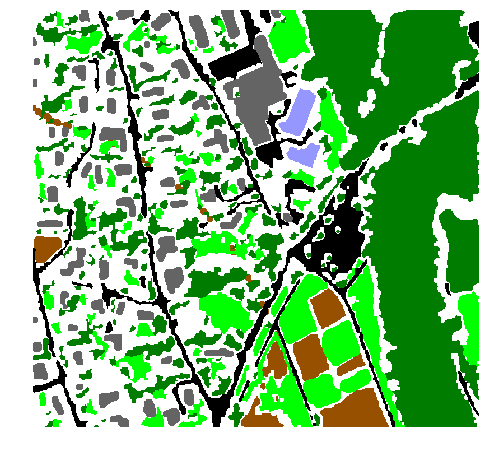

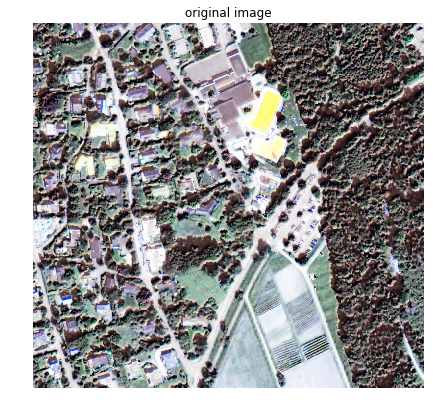

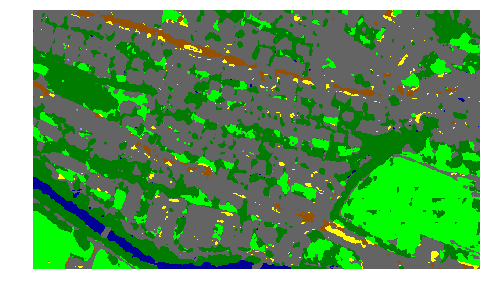

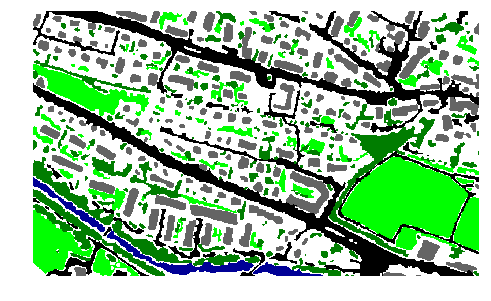

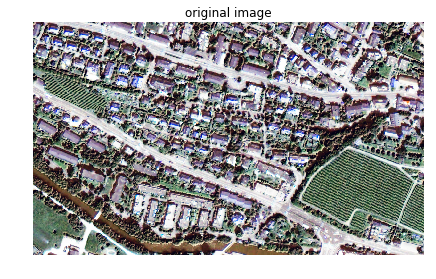

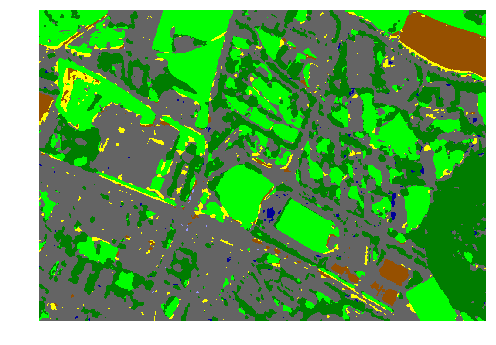

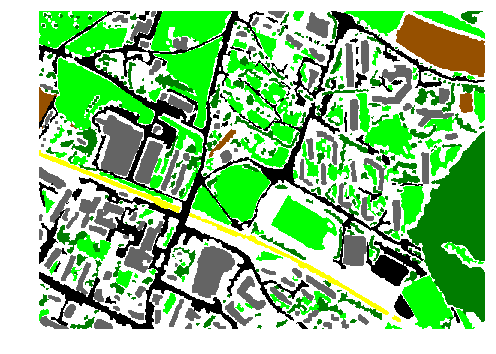

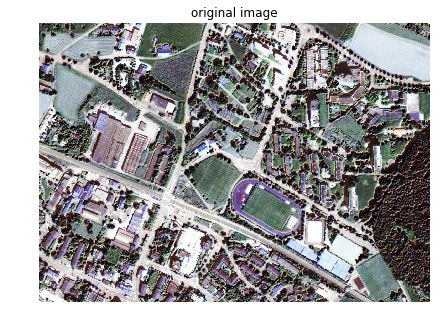

In [21]:
y_pred_im = [convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=16, patch_size=64,
                             stride=64) for i in ids_test]

for img_idx in ids_test:
    # Pred
    plt.figure(figsize=(8,8))
    plt.imshow(y_pred_im[img_idx-16])  # prediction
    plt.axis('off')
    plt.savefig("../Figures/Pred/im_" + str(img_idx+1) + "_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

    # GT
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(gt_label_to_color(gt[img_idx],colors))  # gt stitched together


    # show also original image
    plt.figure(figsize=(7, 7))
    plt.imshow(imgs[img_idx][:, :, :3])
    plt.axis('off')
    plt.savefig("../Figures/Im/im_" + str(img_idx+1) + ".pdf", bbox_inches='tight', pad_inches=0)
    plt.title("original image")

### 3.3. Accuracy Metrics (Test Set)

In [22]:
# Accuracy metrics
y_pred_flattened= np.asarray(flatten(flatten(y_pred_label))).astype('int')
y_test_flattened= np.asarray(flatten(flatten(y_test_nostride))).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

     Buildings      0.802     0.978     0.881    470587
         Trees      0.885     0.869     0.877    545015
         Grass      0.960     0.831     0.891    612397
     Bare Soil      0.880     0.734     0.801     66093
         Water      0.873     0.816     0.844     18705
      Railways      0.078     0.085     0.081     18526
Swimming Pools      0.868     0.844     0.856     10386

   avg / total      0.880     0.871     0.871   1741709

Overall accuracy: 87.098 %


In [23]:
# print to log file
import pandas as pd
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test_flattened[filter_items], y_pred_flattened[filter_items])
df = pd.DataFrame(data={'Precision':precision,
                        'Recall':recall,
                       'f1-score':fscore,
                       'support':support}, index=names_keep)

df.index.name = 'Class'
with open("models_out/acc_class_" + str(class_to_remove) + ".csv", 'w') as f:
    print(df.to_latex(float_format='%.3f'), file=f)  # Python 3.x

In [24]:
#AA_CNN=[87.098, 81.905, 87.839, 81.076, 81.236, 83.891, 81.091, 81.451] #CNN,accuracies
#print("AA for all models: %.3f"%(np.dot(AA_CNN,support)/sum(support)))

## Confidence from Invariance to Image Transformations
https://arxiv.org/pdf/1804.00657.pdf

In [25]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# prediction patches without overlapping patches
# y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# get label
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

3902/3902 [==============================] - 2s 634us/step


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


In [26]:
np.shape(x_test)

(3902, 64, 64, 4)

In [27]:
np.shape(y_test)

(3902, 64, 64)

In [28]:
y = np.equal(y_pred_label, y_test_nostride)

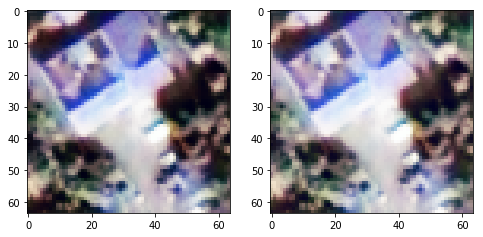

In [29]:
x_aug, y_aug = augment_images_and_gt(x_test_nostride, x_test_nostride, gamma=.8, force=True)

# visualize an image
im_idx = 5
fig, axes  = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(x_test_nostride[im_idx][...,:3])
axes[1].imshow(x_aug[im_idx][...,:3])

3902/3902 [==============================] - 2s 633us/step


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


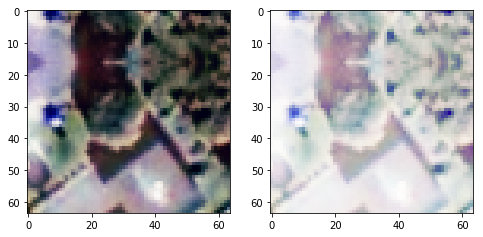

3902/3902 [==============================] - 2s 633us/step


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


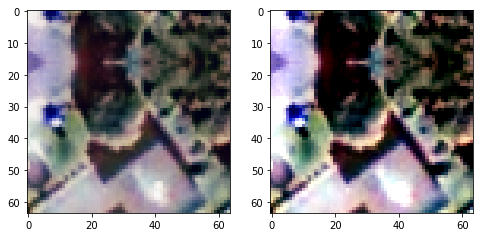

3902/3902 [==============================] - 2s 615us/step


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


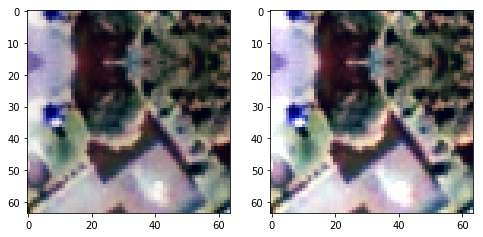

3902/3902 [==============================] - 2s 592us/step


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


In [30]:
y_preds = []
# original
y_pred = model_unet.predict(x_test, verbose=1)
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))
y_preds.append(y_pred)

# TODO horizontal flipping
#x_aug = [np.fliplr(x_test[i]) for i in range(len(x_test))]
#y_preds.append(model.predict(x_aug))
#x_aug, _ = augment_images_and_gt(x_test, x_test, rf_h=True)
#y_preds.append(model_unet.predict(x_aug, verbose=1))

# gamma
x_aug, _ = augment_images_and_gt(x_test, x_test, gamma=.2, force=True)
fig, axes  = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(x_test[im_idx][...,:3])
axes[1].imshow(x_aug[im_idx][...,:3])
plt.show()
y_pred = model_unet.predict(x_aug, verbose=1)
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))
y_preds.append(y_pred)

# contrast
x_aug, _ = augment_images_and_gt(x_test, x_test, contrast=1.5, force=True)
fig, axes  = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(x_test[im_idx][...,:3])
axes[1].imshow(x_aug[im_idx][...,:3])
plt.show()
y_pred = model_unet.predict(x_aug, verbose=1)
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))
y_preds.append(y_pred)

# contrast
x_aug, _ = augment_images_and_gt(x_test, x_test, brightness=1.2, force=True)
fig, axes  = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(x_test[im_idx][...,:3])
axes[1].imshow(x_aug[im_idx][...,:3])
plt.show()
y_pred = model_unet.predict(x_aug, verbose=1)
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))
y_preds.append(y_pred)
#x_aug, _ = augment_images_and_gt(x_test, x_test, blur=True)

In [31]:
y_preds = np.asarray(y_preds)
y_preds.shape

(4, 964, 64, 64, 7)

In [32]:
y_preds = np.transpose(y_preds,(1,2,3,4,0))
y_preds.shape

(964, 64, 64, 7, 4)

In [33]:
idx_train = np.arange(get_offset(imgs,64,64,16,18))
idx_test = np.arange(get_offset(imgs,64,64,16,18),get_offset(imgs,64,64,16,20))

x_train = y_preds[idx_train]
x_test = y_preds[idx_test]

y_train = y[idx_train]
y_test = y[idx_test]


def cat(var):
    return np.concatenate(np.concatenate(var))

x_train = np.transpose(cat(x_train),(2,0,1))
x_test = np.transpose(cat(x_test),(2,0,1))
y_train = cat(y_train)
y_test = cat(y_test)

In [34]:
np.shape(x_train), np.shape(y_train)

((4, 1585152, 7), (1585152,))

In [35]:
from tqdm import tqdm
from copy import deepcopy

In [36]:
# loop all data points
def reorder_truncate_concatenate(y_pred, n_components):
    """ 
    reorder, truncate, concatenate prediction vectors
    y_pred = [n_transforms, n_points, n_classes]
    """
    # reorder
    y_pred_o = deepcopy(y_pred)
    for i in tqdm(range(np.shape(y_pred)[1])): # loop n_points
        order = np.argsort(y_pred_o[0][i])
        # reorder class scores by descending original score
        for j in range(len(y_pred)):  # loop n_transforms
            sort_order = np.flip(np.argsort(y_pred_o[0][i]), axis=0)
            y_pred_o[j][i] = y_pred_o[j][i][sort_order]
    
    # truncate
    y_pred_t = []
    
    y_pred_t = np.asarray([y_pred[:,:n_components] for y_pred in y_pred])
       
    # concatenate
    y_pred_c = np.concatenate(y_pred_t, axis=-1)
    return y_pred_t, y_pred_c

_, x_train = reorder_truncate_concatenate(x_train, 4)

100%|██████████| 1585152/1585152 [00:42<00:00, 37071.61it/s]


In [37]:
_, x_test = reorder_truncate_concatenate(x_test, 4)

100%|██████████| 2363392/2363392 [01:02<00:00, 37563.09it/s]


In [38]:
# convert class vectors to binary class matrices
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [39]:
print(np.shape(y_train),np.shape(y_test))
np.shape(x_train),np.shape(x_test)

(1585152, 2) (2363392, 2)


((1585152, 16), (2363392, 16))

In [40]:
# Train MLP
model_mlp = Sequential()
model_mlp.add(Dense(300, activation='relu', input_shape=(x_train.shape[1:])))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(300, activation='relu'))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(num_classes, activation='softmax'))

model_mlp.summary()

model_mlp.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

batch_size = 2000
epochs = 20
history = model_mlp.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               5100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 602       
Total params: 96,002
Trainable params: 96,002
Non-trainable params: 0
_________________________________________________________________
Train on 1585152 samples, validate on 2363392 samples
Epoch 1/20
1585152/1585152 [==============================] - 8s 5us/step - loss: 0.

In [42]:
model_mlp.save('models_out/model_MLP_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [43]:
model_mlp = load_model('models_out/model_MLP_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')

In [44]:
y_pred = model_mlp.predict(x_test, verbose = 1)
y_pred_label = y_pred[:,1]  # probability to have a good label

2363392/2363392 [==============================] - 69s 29us/step


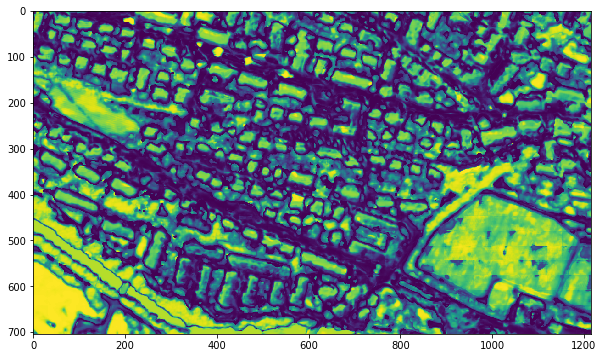

In [49]:
# get patches from pixels
n_patches = get_offset(imgs, 64, 64, 18, 20)
y_pred_label_patches = np.reshape(y_pred_label,(n_patches,64, 64))

# get image from patches
y_pred_label_imgs = convert_patches_to_image(imgs, y_pred_label_patches[..., np.newaxis], 18, 64, 64, 18)
plt.figure(figsize=(10,10))
plt.imshow(y_pred_label_imgs[...,0])

In [46]:
_, support = np.unique(y_test_nostride, return_counts=True)
support = support[1:]

In [47]:
# calculate average certainty by Network
av_cert = []
nans = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(y_pred_label_patches[y_test_nostride[idx_test]==label]))
av_cert = np.asarray(av_cert)
nans = np.asarray(nans)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f" % (names[idx + 1], w))

av_cert[-1] = 0
# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

av_cert_w = (av_cert*support)/sum(support)
cert_unseen_w = av_cert_w[class_to_remove - 1]
cert_seen_w = np.nanmean(np.asarray(av_cert)[av_cert_w != cert_unseen])

print("Average certainty unseen class:\t%.5f" % cert_unseen)
print("Average certainty seen classes:\t%.5f" % cert_seen)
print("Ratio between support-weighted cert. of seen classes / unseen class:\t%.3f" % (cert_seen_w / cert_unseen_w))

Average certainty within class:
          Roads: 0.15896
      Buildings: 0.56421
          Trees: 0.67648
          Grass: 0.70124
      Bare Soil: 0.49895
          Water: 0.85496
       Railways: 0.17015
 Swimming Pools: nan
Average certainty unseen class:	0.15896
Average certainty seen classes:	0.49514
Ratio between support-weighted cert. of seen classes / unseen class:	12.384


/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
